# 03 - SelfClean

## Import necessary libraries and download dataset

In [1]:
!pip install selfclean -Uq


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
import copy
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from selfclean import SelfClean
from selfclean.cleaner.selfclean import PretrainingType

if IN_COLAB:
    !git clone https://github.com/Digital-Dermatology/data-cleaning-hands-on.git
    sys.path.append("data-cleaning-hands-on")
else:
    sys.path.append("../")

from utils import get_oxford_pets3t

We start by downloading our dataset to analyze.

Either you want to analyze your own collection or you can analyze Oxford PetIIIT.

In [4]:
dataset, df = get_oxford_pets3t(
    root_path="../data", return_dataframe=True, transform=transforms.Resize((256, 256))
)
dataset

Oxford PetIIIT already downloaded to `../data`.


Dataset ImageFolder
    Number of datapoints: 7390
    Root location: ../data
    StandardTransform
Transform: Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)

In [5]:
# 2nd option -> analyze your own data
# dataset = ImageFolder(root_path='path/to/dataset')

## Run SelfClean

As a first step, SelfClean will train a model using self-supervised learning on the provided dataset.
Afterwards it will use the learned representations to detect data quality issues using simple scoring functions.

Self-supervised pre-training can take some time that's why we set the number of pre-training epochs here to `10`.
However to acheive optimal performance we suggest letting it run for longer.

Will run the code on one GPU.
STARTUP | distributed init (rank 0): env://
Running on: cuda
Run directory of model: /home/fabian/Documents/_git/GitHub/digital-dermatology/data-cleaning-hands-on/notebooks/DINO-OxfordIIITPet
Data loaded: there are 7390 train images, 462 batches, and a batch size of 16.
Found checkpoint at /tmp/tmpx_35qk8b
Found checkpoint at /tmp/tmpx_35qk8b
Found checkpoint at /tmp/tmpx_35qk8b
Found checkpoint at /tmp/tmpdfji9n7l
Found checkpoint at /tmp/tmpdfji9n7l
Found checkpoint at /tmp/tmpdfji9n7l
Single GPU detected, model will run on single instance.
Single GPU detected, model will run on single instance.
Student and Teacher are built: they are both vit_tiny network.
Found checkpoint at /home/fabian/Documents/_git/GitHub/digital-dermatology/data-cleaning-hands-on/notebooks/DINO-OxfordIIITPet/checkpoints/model_best.pth
=> loaded 'optimizer' from checkpoint: '/home/fabian/Documents/_git/GitHub/digital-dermatology/data-cleaning-hands-on/notebooks/DINO-OxfordIIITPet/c

0it [00:00, ?it/s]
Processing possible near duplicates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2731/2731 [00:27<00:00, 98.92it/s]
Processing possible irrelevant samples: 14779it [00:02, 5780.37it/s]


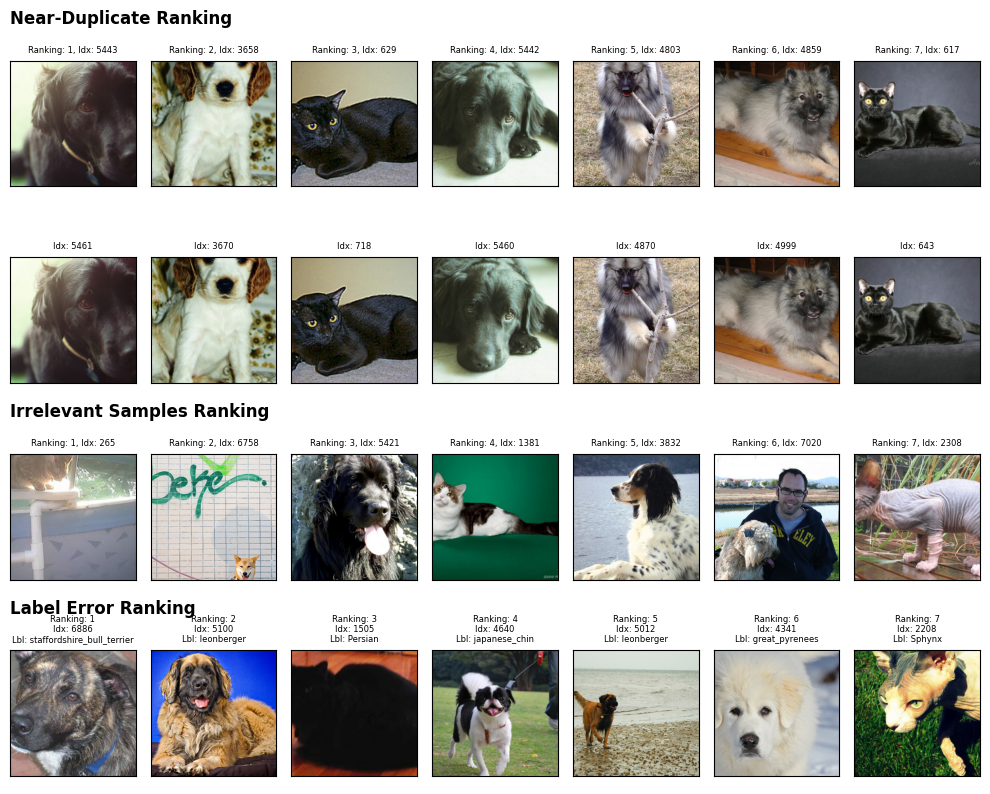

In [6]:
selfclean = SelfClean(
    plot_top_N=7,
)
out_dict = selfclean.run_on_dataset(
    dataset=copy.copy(dataset),
    pretraining_type=PretrainingType.DINO,
    num_workers=24,
    epochs=10,
    batch_size=16,
    dataset_name="OxfordIIITPet",
)

Let's look at each issue type in more detail.

### Near duplicates

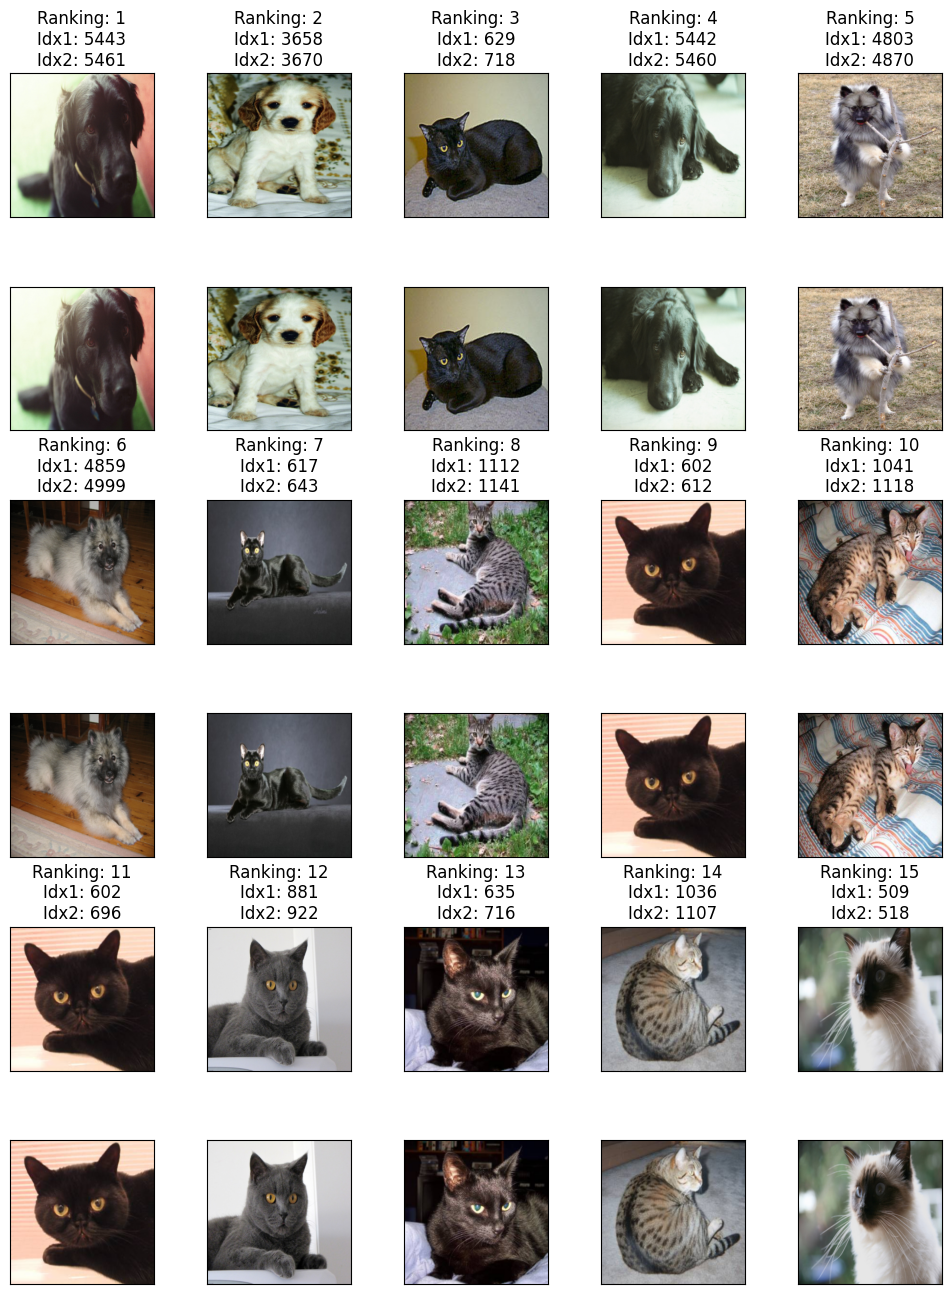

In [7]:
r_index = 0
fig, axes = plt.subplots(6, 5, figsize=(10, 13))
for h_idx, h_ax in enumerate(axes):
    for v_idx, ax in enumerate(h_ax):
        if h_idx % 2 == 1:
            continue

        idx1, idx2 = out_dict["near_duplicates"]["indices"][r_index]
        idx1, idx2 = int(idx1), int(idx2)

        ax.imshow(dataset[idx1][0])
        axes[h_idx + 1, v_idx].imshow(dataset[idx2][0])
        ax.set_title(f"Ranking: {r_index+1}" f"\nIdx1: {idx1}" f"\nIdx2: {idx2}")
        ax.set_xticks([])
        ax.set_yticks([])
        axes[h_idx + 1, v_idx].set_xticks([])
        axes[h_idx + 1, v_idx].set_yticks([])
        r_index += 1

fig.tight_layout()
plt.show()

### Irrelevant Samples

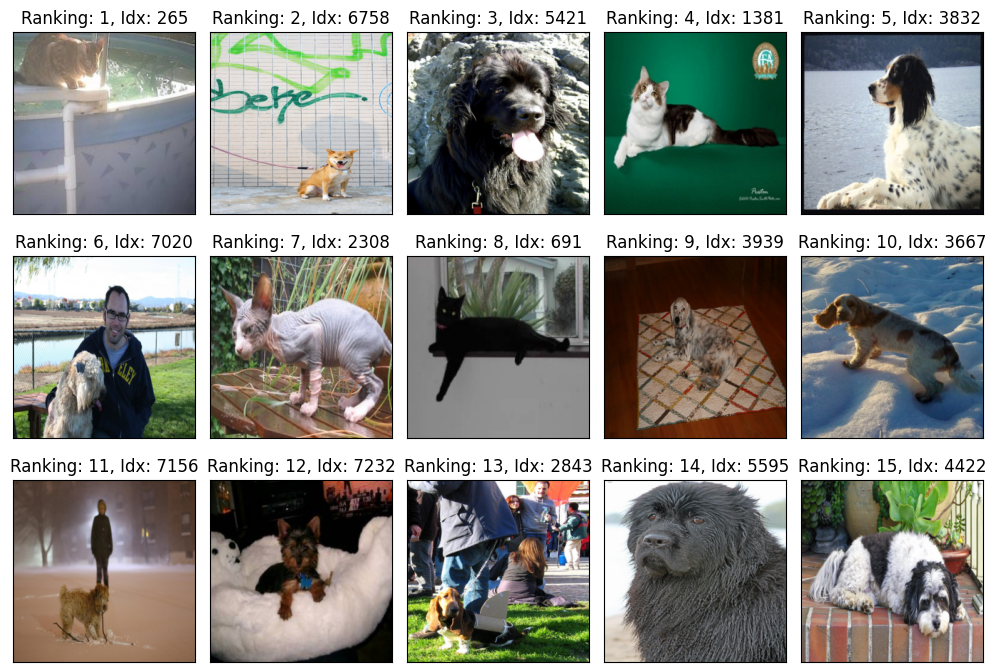

In [8]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = out_dict["irrelevants"]["indices"][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(f"Ranking: {r_index+1}, Idx: {idx}")
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()

### Label Errors

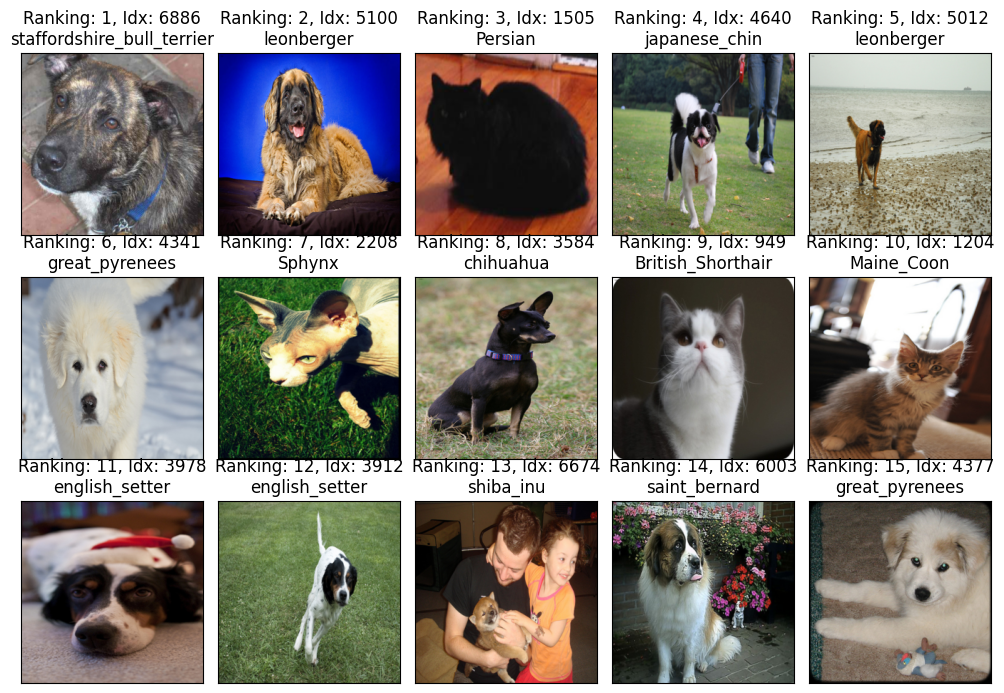

In [9]:
r_index = 0
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
for h_ax in axes:
    for ax in h_ax:
        idx = out_dict["label_errors"]["indices"][r_index]
        ax.imshow(dataset[idx][0])
        ax.set_title(
            f"Ranking: {r_index+1}, Idx: {idx}" f"\n{dataset.classes[dataset[idx][1]]}"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        r_index += 1
fig.tight_layout()
plt.show()